# PRO BTP Test
#### QUESTIONS :
- Quelles sont les 20 premières stations en terme de validations ?
- Proposez une illustration graphique de ce classement.

- Proposez une classification des arrêts en vous basant sur le nombre de validations par catégorie de titre ?

- Quelles prédictions pouvez vous faire pour le nombre de validations dans les stations "OLYMPIADES" et "M. MONTROUGE" sur la plage du 24 au 30 juin ?

#### Importation des bibliothèques

In [1]:
import pandas as pd
from fbprophet import Prophet
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
import plotly.express as px
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_log_error

### Chargement des données 

In [2]:
data= pd.read_csv("./data/validations-sur-le-reseau-ferre-nombre-de-validations-par-jour-1er-sem.csv", sep=";")
data.JOUR = pd.to_datetime(data.JOUR, errors='coerce')#formater les date en datetime
data = data.sort_values(by=["JOUR"])# trier nos données

In [3]:
data.head(10)

JOUR  CODE_STIF_TRNS CODE_STIF_RES CODE_STIF_ARRET  \
624540 2019-01-01             800           803             638   
86262  2019-01-01             810           802              20   
86260  2019-01-01             810           802             189   
713299 2019-01-01             100           110             764   
86258  2019-01-01             810           802             118   
86256  2019-01-01             810           801             913   
86254  2019-01-01             810           801             869   
86252  2019-01-01             810           801             856   
86250  2019-01-01             810           801             856   
86248  2019-01-01             810           801             841   

               LIBELLE_ARRET  ID_REFA_LDA CATEGORIE_TITRE     NB_VALD  
624540  PETIT-JOUY-LES-LOGES      63594.0          NAVIGO  Moins de 5  
86262                 ANTONY      69759.0               ?          50  
86260     CITE UNIVERSITAIRE      70623.0       IMAGINE R         774  
713299         SAINT-FARGEAU      71860.0               ?  Moins de 5  
86258       BURES-SUR-YVETTE      62851.0       AMETHYSTE           6  
86256              VINCENNES      71651.0       IMAGINE R         439  
86254        VAL-DE-FONTENAY      71718.0          NAVIGO        1400  
86252                  TORCY      68129.0             TST         172  
86250                  TORCY      68129.0     NAVIGO JOUR  Moins de 5  
86248          SUCY-BONNEUIL      72929.0       AMETHYSTE          38

In [4]:
#on suppose que le nombre de validations Moins de x est égal à x
data["NB_VALD"] = data["NB_VALD"].apply(lambda column : int(column.replace("Moins de ", "")))

# Question 1 :
- Quelles sont les 20 premières stations en terme de validations ?
- Proposez une illustration graphique de ce classement.

In [5]:
top_20 = data.groupby(["LIBELLE_ARRET"]).agg({'NB_VALD':'sum'}).sort_values(by=["NB_VALD"], ascending=False).head(20)
top_20

NB_VALD
LIBELLE_ARRET                             
LA DEFENSE-GRANDE ARCHE           31142637
GARE DU NORD                      28680591
GARE DE LYON                      27034943
CHATELET-LES HALLES               22227056
SAINT-LAZARE                      17781007
MONTPARNASSE                      15635994
NATION                            13806318
GARE DE L'EST                     13518825
CHARLES DE GAULLE ETOILE          10731021
AUBER                             10419989
BIBLIOTHEQUE FRANCOIS MITTERRAND  10199953
DENFERT-ROCHEREAU                  8477193
HAUSSMANN-SAINT-LAZARE             7442713
REPUBLIQUE                         7147731
LES HALLES                         6898099
LA CHAPELLE                        6459982
AUSTERLITZ                         6256452
SAINT-DENIS                        5173962
BASTILLE                           5003751
SAINT-MICHEL NOTRE DAME            4905069

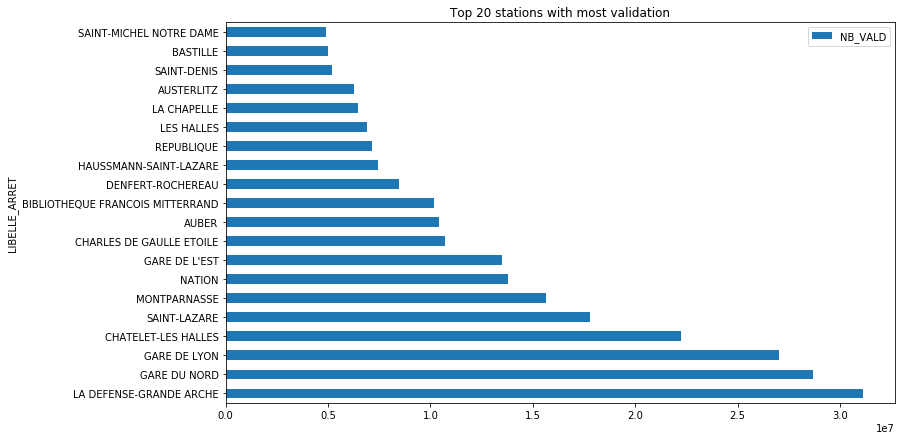

In [6]:
top_20.plot(
    y='NB_VALD',
    use_index=True,
    kind='barh',
    figsize=(12, 7),
    title='Top 20 stations with most validation')

# Question 2 :
- Proposez une classification des arrêts en vous basant sur le nombre de validations par catégorie de titre ?

### Aproche 
__Ici, nous utiliserons une analyse ACP pour mieux comprendre la représentation de nos données. Nous classons ensuite les stataions en fonction de la catégorie de titre et du nombre de validation, et ceci en se basant sur la méthode de clustering que nous présentons les résultats dans un graphe__

#### Pré-traitement de données

In [10]:
#regrouper les validations par stations et categorie du titre
temp = data.groupby(["LIBELLE_ARRET", "CATEGORIE_TITRE"]).agg({'NB_VALD':'sum'}).sort_values(by=["LIBELLE_ARRET"], ascending=False)
temp

NB_VALD
LIBELLE_ARRET CATEGORIE_TITRE         
YERRES        TST                29561
              NAVIGO JOUR          771
              NAVIGO            555607
              IMAGINE R         117962
              FGT                22323
...                                ...
ABBESSES      AMETHYSTE          17217
              NAVIGO JOUR         1295
              NON DEFINI           983
              TST                14108
              ?                   3545

[6152 rows x 1 columns]

In [11]:
# ici, nous transformons les lignes en colonnes pour avoir un tableau avec le nom de la station et les catégories de titre

temp.reset_index(inplace=True)
station_data = pd.DataFrame(columns= ["LIBELLE_ARRET", "?", "AMETHYSTE", "AUTRE TITRE", "FGT", "IMAGINE R", "NAVIGO", "NAVIGO JOUR", "NON DEFINI", "TST"], dtype="Int64")

for i, station in zip(range(0,len(set(temp["LIBELLE_ARRET"]))), set(temp["LIBELLE_ARRET"])) :
    idx = temp["LIBELLE_ARRET"] == station
    
    station_data = station_data.append(
        {'LIBELLE_ARRET': [station], 
         '?' : temp.loc[(idx) & (temp["CATEGORIE_TITRE"] == "?")].NB_VALD.to_numpy(),
         'AMETHYSTE' : temp.loc[(idx) & (temp["CATEGORIE_TITRE"] == "AMETHYSTE")].NB_VALD.to_numpy(),
         'AUTRE TITRE' : temp.loc[(idx) & (temp["CATEGORIE_TITRE"] == "AUTRE TITRE")].NB_VALD.to_numpy(),
         'FGT' : temp.loc[(idx) & (temp["CATEGORIE_TITRE"] == "FGT")].NB_VALD.to_numpy(),
         'IMAGINE R' : temp.loc[(idx) & (temp["CATEGORIE_TITRE"] == "IMAGINE R")].NB_VALD.to_numpy(),
         'NAVIGO' : temp.loc[(idx) & (temp["CATEGORIE_TITRE"] == "NAVIGO")].NB_VALD.to_numpy(),
         'NAVIGO JOUR' : temp.loc[(idx) & (temp["CATEGORIE_TITRE"] == "NAVIGO JOUR")].NB_VALD.to_numpy(),
         'NON DEFINI' : temp.loc[(idx) & (temp["CATEGORIE_TITRE"] == "NON DEFINI")].NB_VALD.to_numpy(),
         'TST' : temp.loc[(idx) & (temp["CATEGORIE_TITRE"] == "TST")].NB_VALD.to_numpy(),
                        }, ignore_index=True)
    
station_data = station_data.applymap(lambda x : 0 if len(x)== 0 else x[0])

In [20]:
#la table avec laquelle nous allons travailler
station_data

LIBELLE_ARRET      ?  AMETHYSTE  AUTRE TITRE     FGT  \
0           SURVILLIERS-FOSSES   7701       5174           95   16686   
1                        SEGUR   4058      16366         1104    9174   
2                           US    460        247            0     527   
3                 POISSONNIERE   6715      33210         1676   38072   
4                   PONT-PETIT    320        820            5    1301   
..                         ...    ...        ...          ...     ...   
727                    PUTEAUX    675       6776           65    6411   
728  LA PLAINE-STADE DE FRANCE  67480      30274          217  131506   
729                 MARAICHERS  19872      58275          818   52568   
730      SARCELLES-SAINT-BRICE   9914      12813          225   46193   
731               NOISY-CHAMPS  35913      54015          580  116399   

     IMAGINE R   NAVIGO  NAVIGO JOUR  NON DEFINI     TST  
0        80890   270127          505           0   22436  
1       148781   461944          605         134   10854  
2         2571    10160          120           0     609  
3       268284  1031527         1059         385   53780  
4        19682     6648           35           0    1205  
..         ...      ...          ...         ...     ...  
727      59511   387595          535           0   12251  
728     317501  2144363         1711           0  303811  
729     140640   854664          815          80   68659  
730     186128   635006          863           0   66783  
731     804075  1749966         1977           5  137541  

[732 rows x 10 columns]

#### Standardiser les variables X

In [13]:
# StandardScaler X
scaler = StandardScaler()
X= station_data.loc[:, station_data.columns != "LIBELLE_ARRET"]
scaler.fit(X)
X_scaled = scaler.transform(X)

#### Analyse en composantes principales

In [14]:
# Application de la PCA avec 90 de l'information
pca = PCA(n_components=0.9)
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)
print(pca.explained_variance_ratio_)# trois composantes de l'ACP

[0.77854727 0.10365999 0.03787293]


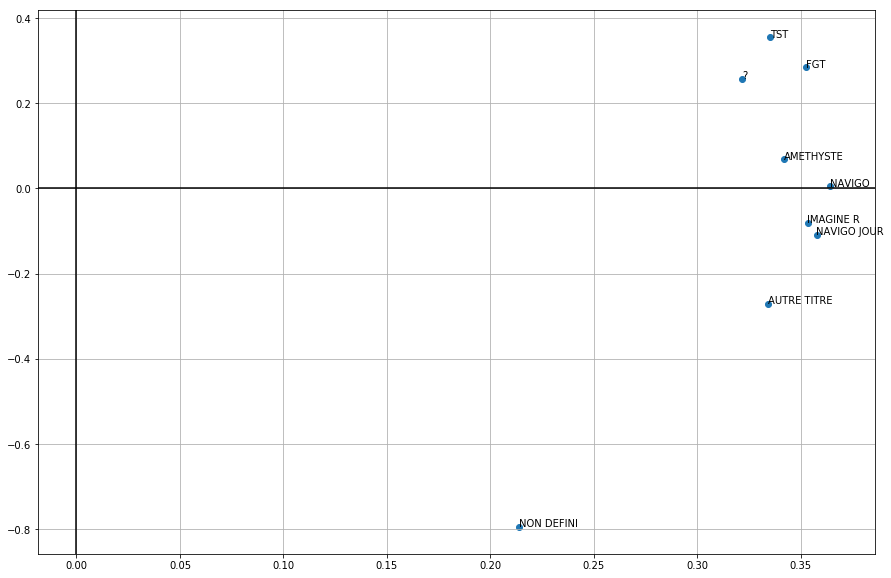

In [15]:
# plot des catégories de titre selon les deux premières composantes
fig, ax = plt.subplots(1, 1,figsize=(15, 10), sharex=True)

ax.scatter(pca.components_[0], pca.components_[1])
ax.grid(True)
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')

for label, x, y in zip(X, pca.components_[0], pca.components_[1]):
    ax.annotate(label, xy=(x, y), xytext=(-0.2, 0.2), textcoords='offset points')
plt.show()

__Analyse: le premier axe du PCA présente le nombre de validations de titres. On remarque une majorité de validations par les titres Navigo, Navigo Jour, IMAGINE R (pour les étudiants), et AMETHYSTE. Ce sont généralement les habitants de l'Ile de France.
Le deuxième axe de l'ACP présente (le côté positif) des abonnements solidaires ainsi que des données non définies. Le côté négatif de l'axe présente les titres non définis (anomalies) ainsi que d'autres titres (forfaits spéciaux).__

#### Classification des titres

In [16]:
clustering = AgglomerativeClustering(n_clusters=6, linkage='ward').fit_predict(X_pca)

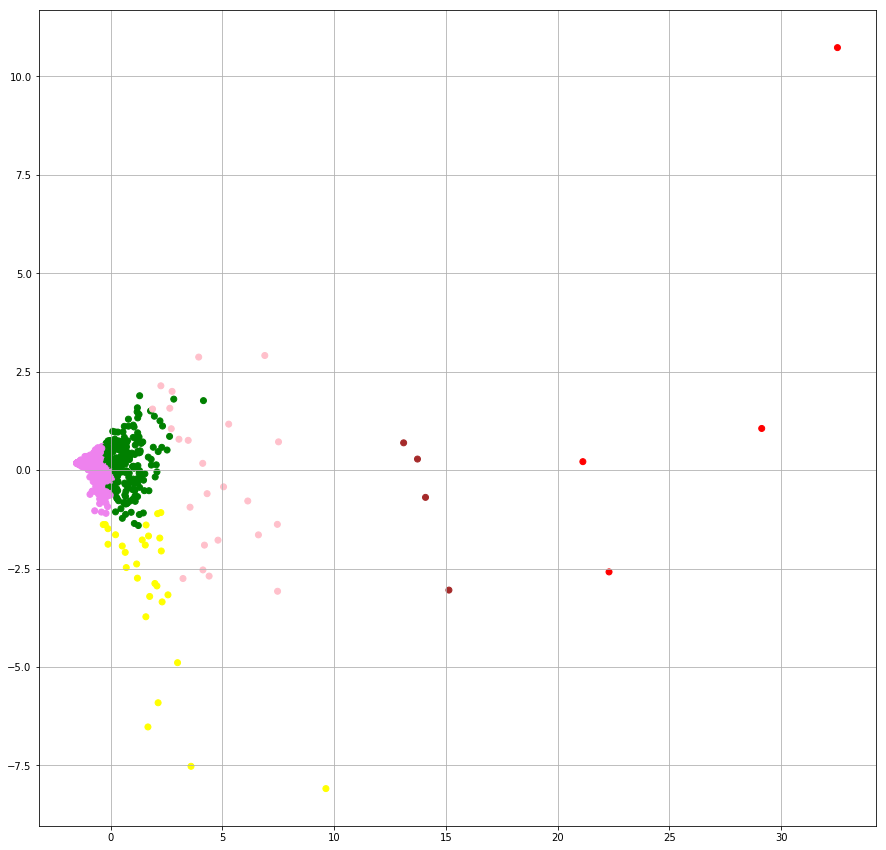

In [17]:
fig, ax = plt.subplots(1, 1,figsize=(15, 15), sharex=True)

colors = ['red','yellow','blue','pink', 'black', 'green', 'orange', 'brown', 'violet']
ax.grid(True)

ax.scatter(X_pca[:, 0], X_pca[:, 1], c= clustering, cmap=matplotlib.colors.ListedColormap(colors))
for label, x, y in zip(station_data["LIBELLE_ARRET"].to_numpy(), X_pca[:, 0], X_pca[:, 1]):
    ax.annotate(s= "", xy=(x, y), xytext=(-0.2, 0.2), textcoords='offset points')
plt.show()

In [18]:
df = px.data.iris()
fig = px.scatter_3d(x=X_pca[:, 0], y=X_pca[:, 1], z=X_pca[:, 2],
              color=clustering)
fig.show()

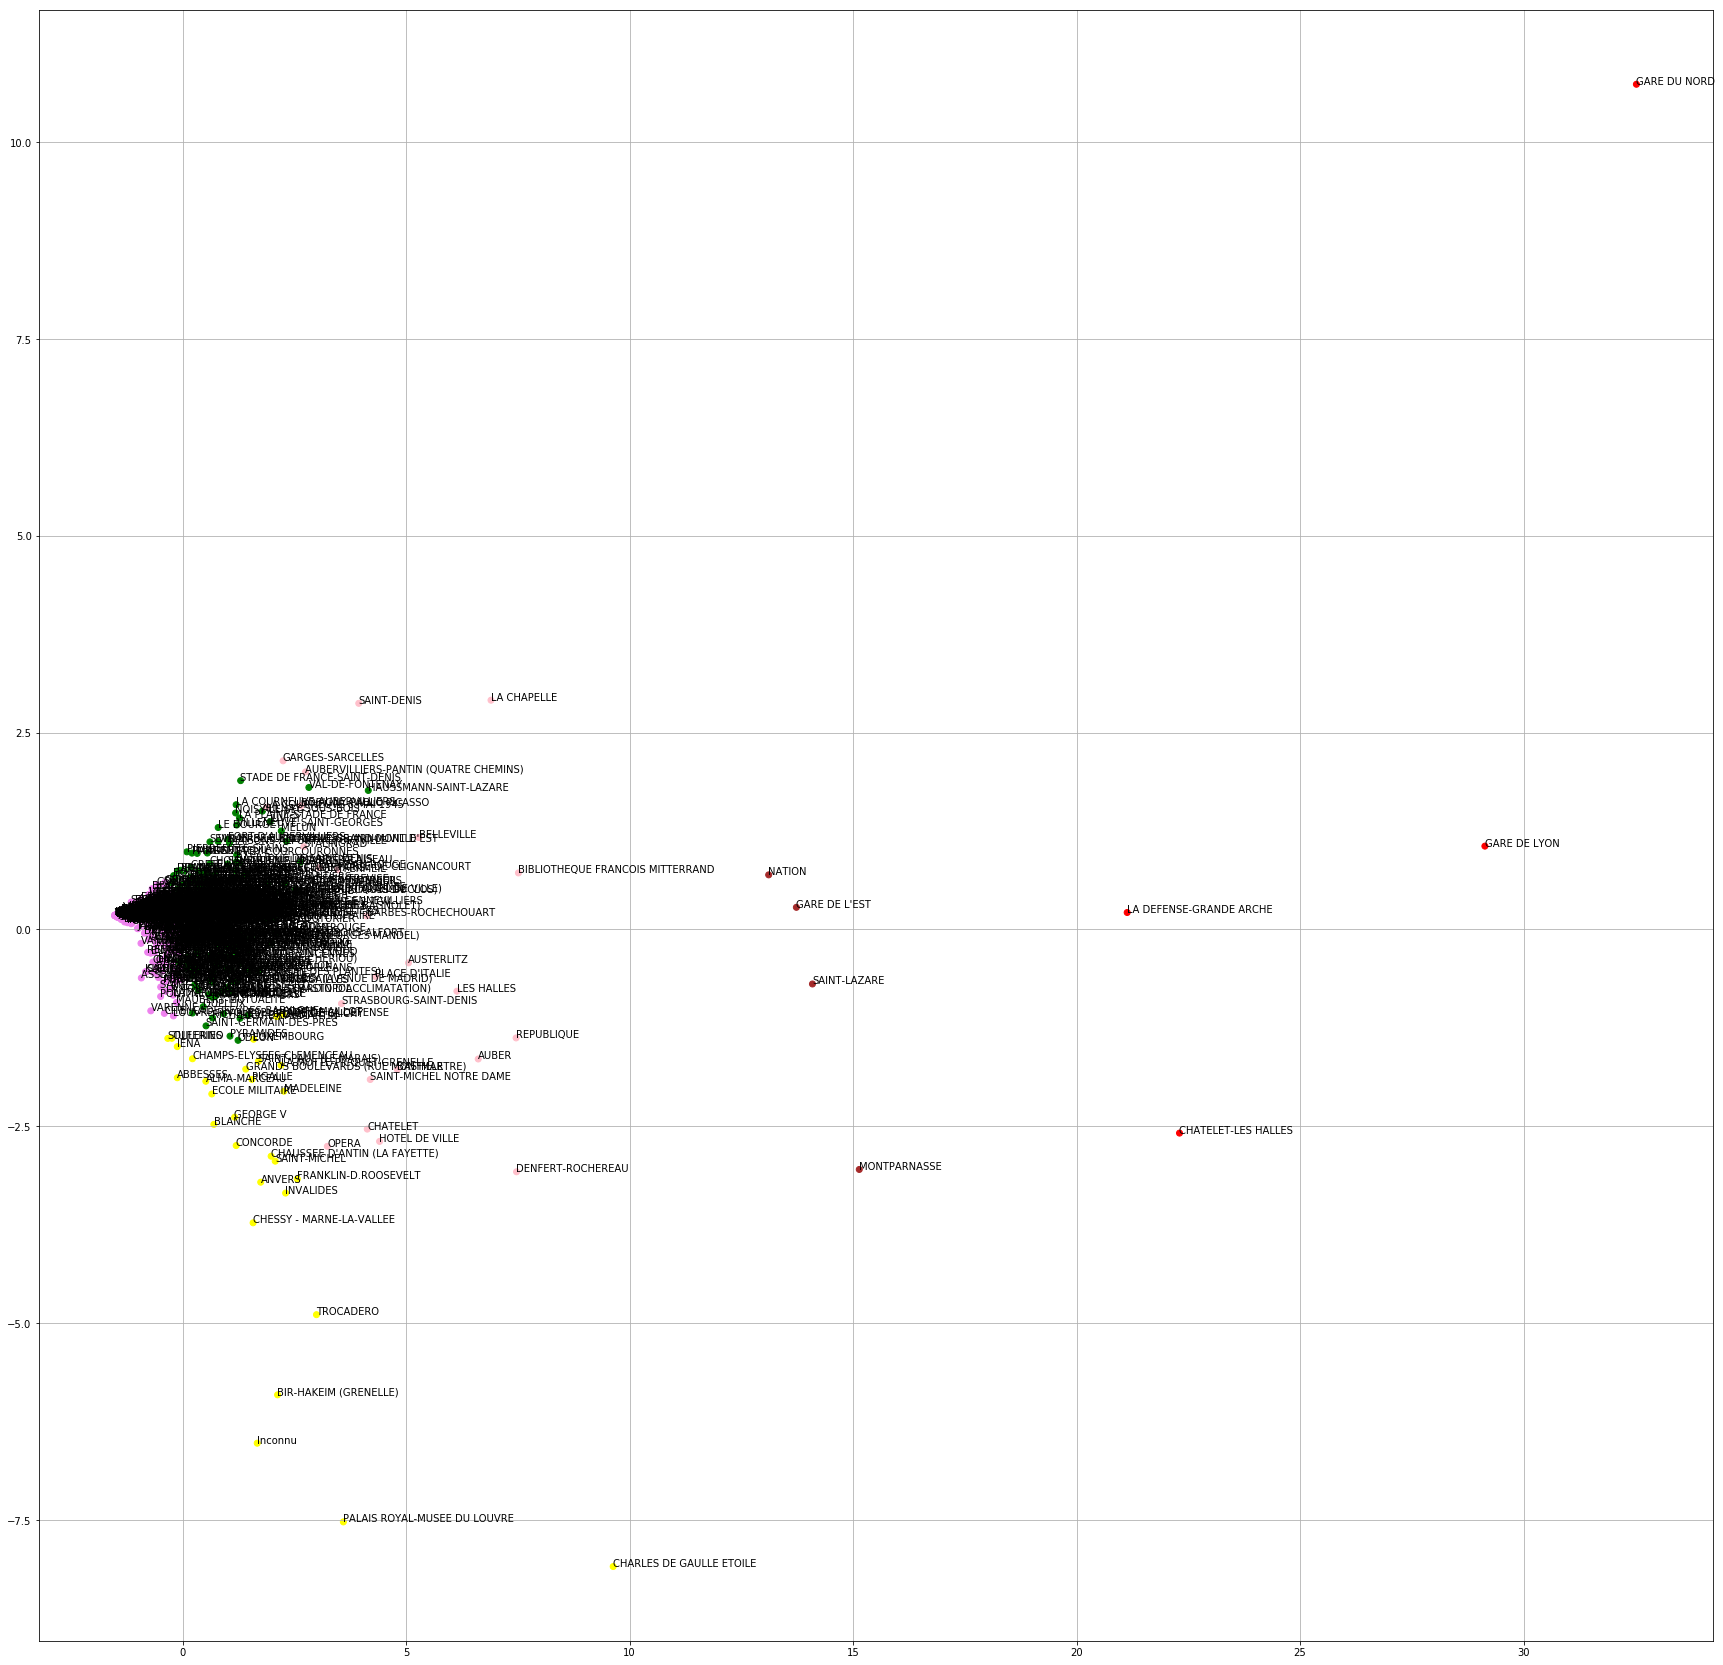

In [23]:
fig, ax = plt.subplots(1, 1,figsize=(30, 30), sharex=True)

colors = ['red','yellow','blue','pink', 'black', 'green', 'orange', 'brown', 'violet']
ax.grid(True)

ax.scatter(X_pca[:, 0], X_pca[:, 1], c= clustering, cmap=matplotlib.colors.ListedColormap(colors))
for label, x, y in zip(station_data["LIBELLE_ARRET"].to_numpy(), X_pca[:, 0], X_pca[:, 1]):
    ax.annotate(s= label, xy=(x, y), xytext=(-0.2, 0.2), textcoords='offset points')
plt.show()

__Analyse : nous remarquons 5 clusters selon la méthode du clustering de l'ACP :__

1. la première classe (rouge) présente les stations qui ont une charge importante de validation : Gare du Nord, Gare de Lyon, La Defense-Grande Arche et Chatelet-Les Halles. Cette classe à un nombre important de validation du titre NAVIGO, ainsi que les titres solidaires pour la Gare du Nord (que vous pouvez clairement voir sur la figure ci-dessus: la Gare du Nord est tout à droite en haut, c'est-à-dire qu'elle dispose d'un grand nombre de validations de billets NAVIGO et de billets à prix réduit).
2. la seconde classe (marron) présente les stations ayant une charge moyenne de validation: Nation, Gare de l'Est, Saint-Lazare et Montparnasse. La majorité de la validation se fait aux titres de NAVIGO, NAVIGO JOUR et IMAGINE R. à l'exception de la gare Montparnasse avec une majorité de la catégorie 'Autre titre'
3. la troisième classe (orange) présente les stations avec moins de validation que la classe précédente. la nouveauté est que le nombre de validations par catégorie varie d'une station à l'autre (stations différenciées). Par exemple: la station Denfert-Rochereau a un grand nombre de validation par "NON défini" (une panne dans la station peut être) plus que les validations par les titres de NAVIGO. Quand à la station Bibliothèque Francois Mitterrand qui un nombre de validation par les titres solidaires plus que les titres NAVIGO et les titres Non défini.
4. la quatrième classe (jaune) présente les stations qui ont le nombre de validation par les catégories «Autre titre» et «Non défini» plus que les autres catégories de titres (cette classe peut présenter des stations qui tombent souvent en panne).
5. la cinquième classe (verte et rose) présente les stations qui ont peu de charge de validation avec un équilibre entre les catégories de titre. Cette classe représente la majorité des stations

# Question 3 
- Quelles prédictions pouvez vous faire pour le nombre de validations dans les stations "OLYMPIADES" et "M. MONTROUGE" sur la plage du 24 au 30 juin ?

### Aproche
Pour augmenter la précision de la prévision, nous faisons une prévision séparée des stations:
1. OLYMPIADES
2. M. MONTROUGE 

Le nombre de validations par jour suie une série temporelle, pour cela nous utiliserons la méthode la plus appropriée pour ce type de série temporelle univariée (Facebook Prophet).

Pour chaque station, nous faisons une prévision du nombre de validation totale (agréger par catégorie) du 24 au 30 juin 2019 . Ensuite, nous faisons une prévision du nombre de validation par catégorie de titre. Enfin, nous additionnons les prévisions par catégories pour les comparer avec la première prévision (prévision totale aggrégée par les catégories).

# Station OLYMPIADES

In [24]:
data_stat1 = data[data["LIBELLE_ARRET"] == "OLYMPIADES"].groupby(["JOUR", "CATEGORIE_TITRE"]).agg({'NB_VALD':'sum'})
data_stat1.reset_index(inplace=True)

In [25]:
data_stat1

JOUR CATEGORIE_TITRE  NB_VALD
0    2019-01-01               ?       53
1    2019-01-01       AMETHYSTE      210
2    2019-01-01             FGT      229
3    2019-01-01       IMAGINE R      660
4    2019-01-01          NAVIGO     2374
...         ...             ...      ...
1465 2019-06-30       IMAGINE R     1479
1466 2019-06-30          NAVIGO     5694
1467 2019-06-30     NAVIGO JOUR        5
1468 2019-06-30      NON DEFINI        5
1469 2019-06-30             TST      566

[1470 rows x 3 columns]

### 1. Prédiction du nombre de validation de toutes les catégories en même temps

In [26]:
data_stat1_all_titles = data_stat1.groupby(["JOUR"]).agg({'NB_VALD':'sum'})

In [27]:
data_stat1_all_titles

NB_VALD
JOUR               
2019-01-01     3764
2019-01-02    14074
2019-01-03    15902
2019-01-04    16644
2019-01-05    11062
...             ...
2019-06-26    19909
2019-06-27    20034
2019-06-28    20415
2019-06-29    12149
2019-06-30     8633

[181 rows x 1 columns]

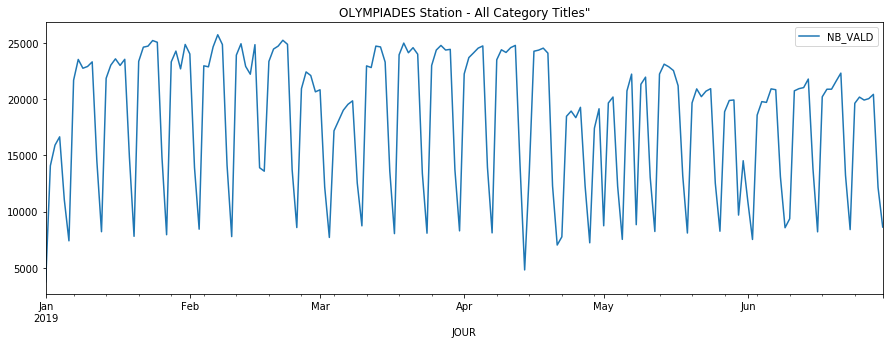

In [28]:
data_stat1_all_titles.plot(
    use_index=True,
    y='NB_VALD',
    figsize=(15, 5),
    title='OLYMPIADES Station - All Category Titles"')

In [29]:
# changer le DataFrame avec deux colonnes ds et y (pour la prévision avec Facebook Prophet)
data_stat1_all_titles.reset_index(inplace=True)
data_stat1_all_titles = data_stat1_all_titles.rename(columns={"JOUR": "ds", "NB_VALD": "y"})

In [30]:
# Sépration de jeux d'entrainement et de jeux de test
idx = data_stat1_all_titles.ds.dt.date < datetime.date(year=2019, month=6, day=24)
train_data = data_stat1_all_titles[idx]
test_data = data_stat1_all_titles[~idx]

In [31]:
# Entrainement du modèle
m = Prophet(changepoint_prior_scale = 0.01, seasonality_prior_scale = 0.1, holidays_prior_scale =10, interval_width=0.95) # paramètres obtenus après le paramètres obtenus après le tuning
m.fit(train_data)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [32]:
#Prévision 
future = m.make_future_dataframe(periods=7)
forecast = m.predict(future)

In [33]:
# données de prévision : yhat : valeur prédite, yhat_lower : valeur prédite min, yhat_upper : valeur prédite max
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

ds          yhat    yhat_lower    yhat_upper
174 2019-06-24  18672.653575  12932.847112  24778.333922
175 2019-06-25  20146.337996  13749.933843  26211.915796
176 2019-06-26  19631.270725  13365.194359  25966.540062
177 2019-06-27  20408.346666  14096.098783  26563.551471
178 2019-06-28  20715.925258  15080.219197  27148.441506
179 2019-06-29  11887.294664   5452.904995  18311.252719
180 2019-06-30   6838.678201    273.033729  12829.436450

Text(0.5,0,'Date')

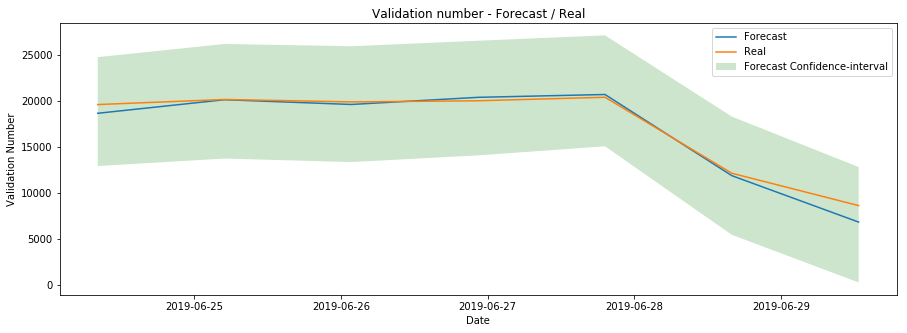

In [34]:
fig, ax = plt.subplots(1, 1,figsize=(15, 5), sharex=True)

ax.set_xticklabels(test_data.ds.dt.date)
sns.lineplot(x="ds", y="yhat", data=forecast.tail(7), ax=ax)
ax.fill_between(forecast.tail(7).ds, forecast.tail(7).yhat_lower, forecast.tail(7).yhat_upper, facecolor='green', alpha=0.2)
sns.lineplot(x="ds", y="y", data=test_data, ax=ax)
ax.legend(labels=["Forecast", "Real", "Forecast Confidence-interval"]);
ax.set_title("Validation number - Forecast / Real") 
ax.set_ylabel("%s" % "Validation Number")
ax.set_xlabel("Date")

In [35]:
print("R2-Score (Higher is better) : {0:.2f}%".format(r2_score(test_data.y, forecast.tail(7).yhat)*100))
print("MSLE (Lower is better) : {0:.2f}".format(mean_squared_log_error(test_data.y, forecast.tail(7).yhat)))
print("MAE (Lower is better) : {0:.2f}".format(mean_absolute_error(test_data.y, forecast.tail(7).yhat)))

R2-Score (Higher is better) : 96.77%
MSLE (Lower is better) : 0.01
MAE (Lower is better) : 569.29


### 2. Prédiction du nombre de validation des catégories séparément

In [36]:
set(data_stat1["CATEGORIE_TITRE"])

{'?',
 'AMETHYSTE',
 'AUTRE TITRE',
 'FGT',
 'IMAGINE R',
 'NAVIGO',
 'NAVIGO JOUR',
 'NON DEFINI',
 'TST'}

In [37]:
train_dict = {}
test_dict = {}
forecast_dict = {}

#Entrainement et prédiction pour chaque catégories : 9 modèles
for category in set(data_stat1["CATEGORIE_TITRE"]) :
    
    data_prev = data_stat1[data_stat1["CATEGORIE_TITRE"]== category].rename(columns={"JOUR": "ds", "NB_VALD": "y"}).drop(columns=["CATEGORIE_TITRE"])

    
    # Sépration de jeux d'entrainement et de jeux de test
    idx = data_prev.ds.dt.date < datetime.date(year=2019, month=6, day=24)
    train_dict[category] = data_prev[idx]
    test_dict[category] = data_prev[~idx]
    
    # Entrainement du modèle
    m = Prophet(changepoint_prior_scale = 0.01, seasonality_prior_scale = 0.1, holidays_prior_scale =10, interval_width=0.95) # paramètres obtenus après le paramètres obtenus après le tuning
    m.fit(train_dict[category])
    
    #Prévision 
    future = m.make_future_dataframe(periods=7)
    forecast_dict[category] = m.predict(future)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

### Example titre 1 : Titre NAVIGO 

In [38]:
# données de prévision : yhat : valeur prédite, yhat_lower : valeur prédite min, yhat_upper : valeur prédite max
forecast_dict["NAVIGO"][['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

ds          yhat    yhat_lower    yhat_upper
174 2019-06-24  12569.147064   9065.028647  16247.827154
175 2019-06-25  13818.532490  10237.209942  17513.373930
176 2019-06-26  13355.559163   9821.651728  17095.848714
177 2019-06-27  13973.753842  10194.462982  17504.916054
178 2019-06-28  14079.400333  10080.943766  17843.982213
179 2019-06-29   8051.809102   4503.108700  11724.007661
180 2019-06-30   5124.043250   1644.848095   8748.005593

In [39]:
test_dict["NAVIGO"]

ds      y
1412 2019-06-24  13889
1421 2019-06-25  14525
1430 2019-06-26  14289
1439 2019-06-27  14566
1448 2019-06-28  14608
1457 2019-06-29   8086
1466 2019-06-30   5694

In [40]:
navigo_forecast = forecast_dict["NAVIGO"][['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7).yhat

print("R2-Score NAVIGO (Higher is better) : {0:.2f}%".format(r2_score(test_dict["NAVIGO"].y, navigo_forecast)*100))
print("MSLE NAVIGO (Lower is better) : {0:.2f}".format(mean_squared_log_error(test_dict["NAVIGO"].y, navigo_forecast)))
print("MAE NAVIGO (Lower is better) : {0:.2f}".format(mean_absolute_error(test_dict["NAVIGO"].y, navigo_forecast)))

R2-Score NAVIGO (Higher is better) : 95.11%
MSLE NAVIGO (Lower is better) : 0.00
MAE NAVIGO (Lower is better) : 669.25


### Exemple titre2 :  IMAGINE R

In [41]:
# données de prévision : yhat : valeur prédite, yhat_lower : valeur prédite min, yhat_upper : valeur prédite max
forecast_dict["AMETHYSTE"][['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

ds        yhat  yhat_lower  yhat_upper
174 2019-06-24  536.362958  424.522713  652.230219
175 2019-06-25  597.102191  488.515185  713.189364
176 2019-06-26  598.903835  479.376859  712.213943
177 2019-06-27  623.009667  513.384863  731.690882
178 2019-06-28  645.754595  526.326561  757.722144
179 2019-06-29  615.042379  497.169967  726.363976
180 2019-06-30  429.254240  322.740969  534.086475

In [42]:
test_dict["AMETHYSTE"]

ds    y
1408 2019-06-24  535
1417 2019-06-25  545
1426 2019-06-26  571
1435 2019-06-27  544
1444 2019-06-28  569
1453 2019-06-29  520
1462 2019-06-30  412

In [43]:
AMETHYSTE_forecast = forecast_dict["AMETHYSTE"][['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7).yhat
print("MSLE NAVIGO (Lower is better) : {0:.2f}".format(mean_squared_log_error(test_dict["AMETHYSTE"].y, AMETHYSTE_forecast)))
print("MAE NAVIGO (Lower is better) : {0:.2f}".format(mean_absolute_error(test_dict["AMETHYSTE"].y, AMETHYSTE_forecast)))

MSLE NAVIGO (Lower is better) : 0.01
MAE NAVIGO (Lower is better) : 49.92


### Affichage de la prédiction de tous les titres

Text(0.5,0,'Date')

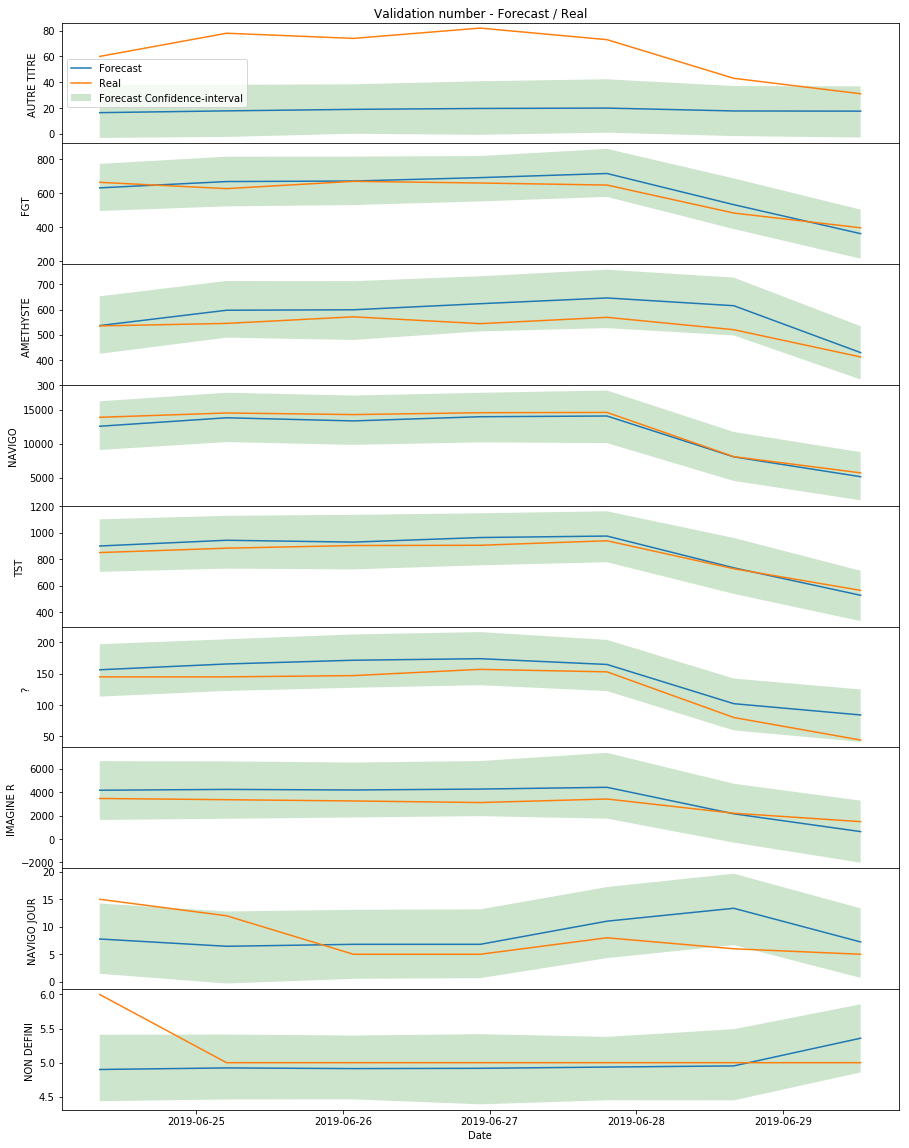

In [44]:
fig, ax_arr = plt.subplots(9, 1,figsize=(15, 20), sharex=True, gridspec_kw={'hspace': 0})

for i, category in zip(range (0,9), set(data_stat1["CATEGORIE_TITRE"])) :  

    sns.lineplot(x="ds", y="yhat", data=forecast_dict[category].tail(7), ax=ax_arr[i])
    ax_arr[i].fill_between(forecast_dict[category].tail(7).ds, forecast_dict[category].tail(7).yhat_lower, forecast_dict[category].tail(7).yhat_upper, facecolor='green', alpha=0.2)
    sns.lineplot(x="ds", y="y", data=test_dict[category], ax=ax_arr[i])
    ax_arr[i].set_ylabel("%s" % "{} ".format(category))

    
ax_arr[0].legend(labels=["Forecast", "Real", "Forecast Confidence-interval"])
ax_arr[0].set_title("Validation number - Forecast / Real") 
ax_arr[i].set_xticklabels(test_dict[category].ds.dt.date)
ax_arr[i].set_xlabel("Date")

### Addition des prédictions par catégories

In [32]:
sum_prev = 0
sum_real = 0
for category in set(data_stat1["CATEGORIE_TITRE"]): 
    sum_prev = sum_prev + abs(forecast_dict[category].tail(7).yhat.to_numpy())
    sum_real = sum_real + abs(test_dict[category].y.to_numpy())

Text(0.5,0,'Date')

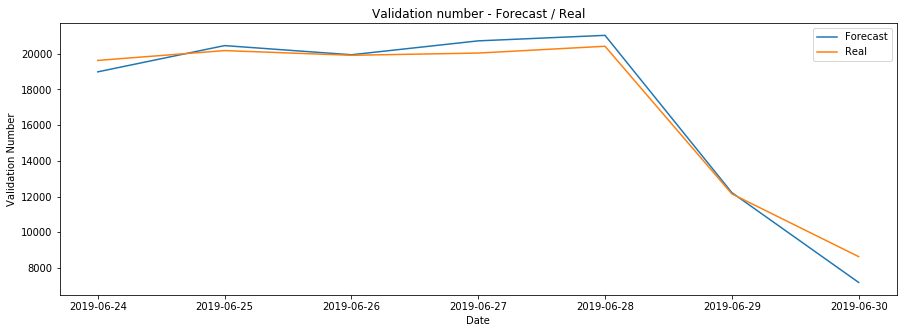

In [33]:
fig, ax = plt.subplots(1, 1,figsize=(15, 5), sharex=True)

ax.set_xticklabels(test_data.ds.dt.date)
sns.lineplot(x=test_data.ds.dt.date, y=sum_prev, ax=ax)
sns.lineplot(x=test_data.ds.dt.date, y=sum_real, ax=ax)
ax.legend(labels=["Forecast", "Real", "Forecast Interval"]);
ax.set_title("Validation number - Forecast / Real") 
ax.set_ylabel("%s" % "Validation Number")
ax.set_xlabel("Date")

In [35]:
print("R2-Score (Higher is better) : {0:.2f}%".format(r2_score(sum_real, sum_prev)))
print("MSLE (Lower is better) : {0:.2f}".format(mean_squared_log_error(sum_real, sum_prev)))
print("MAE (Lower is better) : {0:.2f}".format(mean_absolute_error(sum_real, sum_prev)))

R2-Score (Higher is better) : 0.98%
MSLE (Lower is better) : 0.01
MAE (Lower is better) : 537.12


### Conclustion 
__Le résultat de la prédiction est légèrement amélioré après avoir utilisé 9 modèles au lieu d'un seul pour prédire le nombre total de validations__
__NB :__
1. La bande verte représente l'intervalle de confiance de la prévision
2. Le modèle à été tuning avant utilisation (voir le noteboook hyperparameter tuning)
3. prévoir le nombre de validations par la catégorie "Autre titre" est difficile par le modèle car il s'agit d'une variable imprévisible

# Station M. MONTROUGE

# Station M. MONTROUGE

In [71]:
data_stat2 = data[data["LIBELLE_ARRET"] == "M. MONTROUGE"].groupby(["JOUR", "CATEGORIE_TITRE"]).agg({'NB_VALD':'sum'})

In [72]:
data_stat2.reset_index(inplace=True)

In [73]:
data_stat2

JOUR CATEGORIE_TITRE  NB_VALD
0    2019-01-01               ?       79
1    2019-01-01       AMETHYSTE       76
2    2019-01-01             FGT       82
3    2019-01-01       IMAGINE R      511
4    2019-01-01          NAVIGO     1838
...         ...             ...      ...
1483 2019-06-30       IMAGINE R     1147
1484 2019-06-30          NAVIGO     4168
1485 2019-06-30     NAVIGO JOUR        6
1486 2019-06-30      NON DEFINI        5
1487 2019-06-30             TST      261

[1488 rows x 3 columns]

### 1. Prédiction du nombre de validation de toutes les catégories en même temps

In [74]:
data_stat2_all_titles = data_stat2.groupby(["JOUR"]).agg({'NB_VALD':'sum'})

In [75]:
data_stat2_all_titles

NB_VALD
JOUR               
2019-01-01     2689
2019-01-02    13436
2019-01-03    15746
2019-01-04    16380
2019-01-05     8977
...             ...
2019-06-26    20526
2019-06-27    20901
2019-06-28    20540
2019-06-29     9912
2019-06-30     6064

[181 rows x 1 columns]

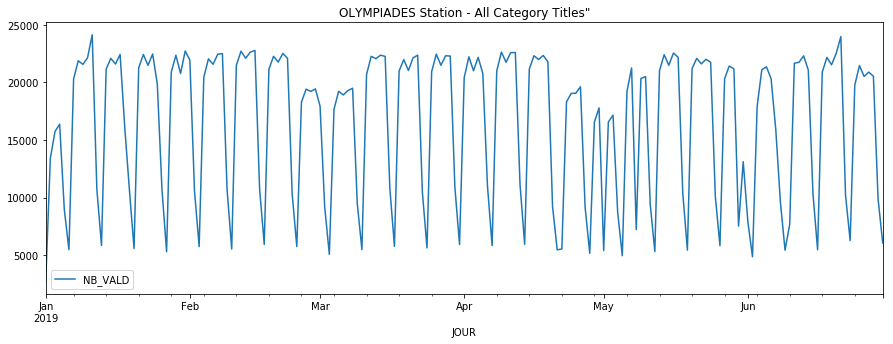

In [76]:
data_stat2_all_titles.plot(
    use_index=True,
    y='NB_VALD',
    figsize=(15, 5),
    title='OLYMPIADES Station - All Category Titles"')

In [77]:
# changer le DataFrame avec deux colonnes ds et y (pour la prévision avec Facebook Prophet)
data_stat2_all_titles.reset_index(inplace=True)
data_stat2_all_titles = data_stat2_all_titles.rename(columns={"JOUR": "ds", "NB_VALD": "y"})

In [78]:
# Sépration de jeux d'entrainement et de jeux de test
idx = data_stat2_all_titles.ds.dt.date < datetime.date(year=2019, month=6, day=24)
train_data = data_stat2_all_titles[idx]
test_data = data_stat2_all_titles[~idx]

In [79]:
# Entrainement du modèle
m = Prophet(changepoint_prior_scale = 0.01, seasonality_prior_scale = 0.1, holidays_prior_scale =10, interval_width=0.95) # paramètres obtenus après le paramètres obtenus après le tuning
m.fit(train_data)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [80]:
#Prévision 
future = m.make_future_dataframe(periods=7)
forecast = m.predict(future)

In [81]:
# données de prévision : yhat : valeur prédite, yhat_lower : valeur prédite min, yhat_upper : valeur prédite max
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

ds          yhat    yhat_lower    yhat_upper
174 2019-06-24  18619.734070  12452.059171  24660.571721
175 2019-06-25  20250.129456  13941.864097  26495.275984
176 2019-06-26  19193.983328  13123.394621  25625.022798
177 2019-06-27  20240.211199  14180.884525  26555.996789
178 2019-06-28  19913.989544  13527.624746  25802.634707
179 2019-06-29   9757.786039   3832.504880  16170.331379
180 2019-06-30   5325.400730   -580.342124  11406.778177

Text(0.5,0,'Date')

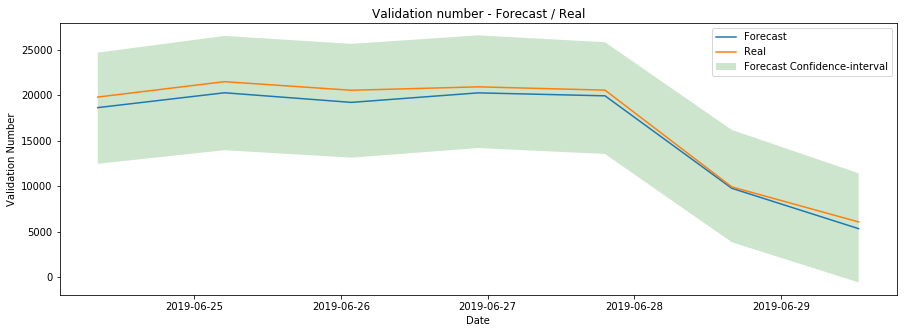

In [82]:
fig, ax = plt.subplots(1, 1,figsize=(15, 5), sharex=True)

ax.set_xticklabels(test_data.ds.dt.date)
sns.lineplot(x="ds", y="yhat", data=forecast.tail(7), ax=ax)
ax.fill_between(forecast.tail(7).ds, forecast.tail(7).yhat_lower, forecast.tail(7).yhat_upper, facecolor='green', alpha=0.2)
sns.lineplot(x="ds", y="y", data=test_data, ax=ax)
ax.legend(labels=["Forecast", "Real", "Forecast Confidence-interval"]);
ax.set_title("Validation number - Forecast / Real") 
ax.set_ylabel("%s" % "Validation Number")
ax.set_xlabel("Date")

In [83]:
print("R2-Score (Higher is better) : {0:.2f}%".format(r2_score(test_data.y, forecast.tail(7).yhat)*100))
print("MSLE (Lower is better) : {0:.2f}".format(mean_squared_log_error(test_data.y, forecast.tail(7).yhat)))
print("MAE (Lower is better) : {0:.2f}".format(mean_absolute_error(test_data.y, forecast.tail(7).yhat)))

R2-Score (Higher is better) : 97.47%
MSLE (Lower is better) : 0.00
MAE (Lower is better) : 841.82


### 2. Prédiction du nombre de validation des catégories séparément

In [84]:
set(data_stat2["CATEGORIE_TITRE"])

{'?',
 'AMETHYSTE',
 'AUTRE TITRE',
 'FGT',
 'IMAGINE R',
 'NAVIGO',
 'NAVIGO JOUR',
 'NON DEFINI',
 'TST'}

In [85]:
train_dict = {}
test_dict = {}
forecast_dict = {}

for category in set(data_stat2["CATEGORIE_TITRE"]) :
    
    data_prev = data_stat2[data_stat2["CATEGORIE_TITRE"]== category].rename(columns={"JOUR": "ds", "NB_VALD": "y"}).drop(columns=["CATEGORIE_TITRE"])

    
    # Sépration de jeux d'entrainement et de jeux de test
    idx = data_prev.ds.dt.date < datetime.date(year=2019, month=6, day=24)
    train_dict[category] = data_prev[idx]
    test_dict[category] = data_prev[~idx]
    
    # Entrainement du modèle
    m = Prophet(changepoint_prior_scale = 0.01, seasonality_prior_scale = 0.1, holidays_prior_scale =10, interval_width=0.95) # paramètres obtenus après le paramètres obtenus après le tuning
    m.fit(train_dict[category])
    
    #Prévision 
    future = m.make_future_dataframe(periods=7)
    forecast_dict[category] = m.predict(future)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

### Titre NAVIGO 

In [86]:
# données de prévision : yhat : valeur prédite, yhat_lower : valeur prédite min, yhat_upper : valeur prédite max
forecast_dict["NAVIGO"][['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

ds          yhat    yhat_lower    yhat_upper
174 2019-06-24  14717.099214   9682.134723  19465.223741
175 2019-06-25  16083.390158  11140.083398  21042.324728
176 2019-06-26  15079.793286   9674.491125  19968.720214
177 2019-06-27  16011.431222  11180.962374  20634.793247
178 2019-06-28  15486.040051  10700.174970  20554.678433
179 2019-06-29   6901.548124   2081.881042  11831.391988
180 2019-06-30   3694.343209  -1651.150930   8404.420799

In [87]:
test_dict["NAVIGO"]

ds      y
1430 2019-06-24  15874
1439 2019-06-25  17412
1448 2019-06-26  16402
1457 2019-06-27  16797
1466 2019-06-28  16314
1475 2019-06-29   7102
1484 2019-06-30   4168

In [88]:
navigo_forecast = forecast_dict["NAVIGO"][['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7).yhat

print("R2-Score NAVIGO (Higher is better) : {0:.2f}%".format(r2_score(test_dict["NAVIGO"].y, navigo_forecast)*100))
print("MSLE NAVIGO (Lower is better) : {0:.2f}".format(mean_squared_log_error(test_dict["NAVIGO"].y, navigo_forecast)))
print("MAE NAVIGO (Lower is better) : {0:.2f}".format(mean_absolute_error(test_dict["NAVIGO"].y, navigo_forecast)))

R2-Score NAVIGO (Higher is better) : 96.36%
MSLE NAVIGO (Lower is better) : 0.01
MAE NAVIGO (Lower is better) : 870.76


### Titre IMAGINE R

In [89]:
# données de prévision : yhat : valeur prédite, yhat_lower : valeur prédite min, yhat_upper : valeur prédite max
forecast_dict["AMETHYSTE"][['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

ds        yhat  yhat_lower  yhat_upper
174 2019-06-24  189.905442  144.728628  233.825192
175 2019-06-25  209.794634  163.895151  258.004426
176 2019-06-26  215.533000  171.662963  258.986509
177 2019-06-27  218.814748  173.726085  265.482085
178 2019-06-28  219.243670  173.097872  264.510271
179 2019-06-29  175.097070  129.559777  221.911257
180 2019-06-30  137.765582   89.665744  183.966217

In [90]:
test_dict["AMETHYSTE"]

ds    y
1426 2019-06-24  170
1435 2019-06-25  172
1444 2019-06-26  188
1453 2019-06-27  188
1462 2019-06-28  170
1471 2019-06-29  138
1480 2019-06-30  137

In [91]:
AMETHYSTE_forecast = forecast_dict["AMETHYSTE"][['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7).yhat
print("MSLE NAVIGO (Lower is better) : {0:.2f}".format(mean_squared_log_error(test_dict["AMETHYSTE"].y, AMETHYSTE_forecast)))
print("MAE NAVIGO (Lower is better) : {0:.2f}".format(mean_absolute_error(test_dict["AMETHYSTE"].y, AMETHYSTE_forecast)))

MSLE NAVIGO (Lower is better) : 0.03
MAE NAVIGO (Lower is better) : 29.02


### Affichage de la prédiction de tout les titres

Text(0.5,0,'Date')

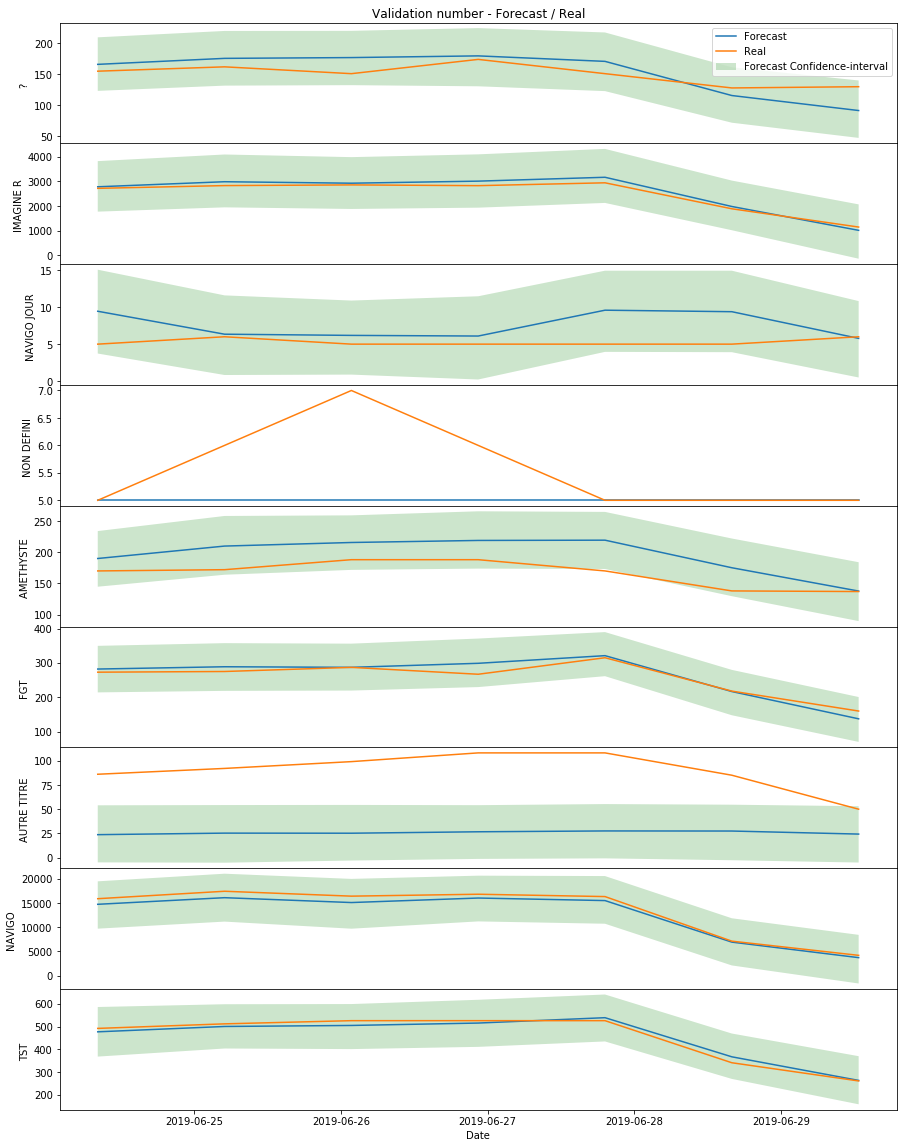

In [92]:
fig, ax_arr = plt.subplots(9, 1,figsize=(15, 20), sharex=True, gridspec_kw={'hspace': 0})

for i, category in zip(range (0,9), set(data_stat2["CATEGORIE_TITRE"])) :  

    sns.lineplot(x="ds", y="yhat", data=forecast_dict[category].tail(7), ax=ax_arr[i])
    ax_arr[i].fill_between(forecast_dict[category].tail(7).ds, forecast_dict[category].tail(7).yhat_lower, forecast_dict[category].tail(7).yhat_upper, facecolor='green', alpha=0.2)
    sns.lineplot(x="ds", y="y", data=test_dict[category], ax=ax_arr[i])
    ax_arr[i].set_ylabel("%s" % "{} ".format(category))

    
ax_arr[0].legend(labels=["Forecast", "Real", "Forecast Confidence-interval"])
ax_arr[0].set_title("Validation number - Forecast / Real") 
ax_arr[i].set_xticklabels(test_dict[category].ds.dt.date)
ax_arr[i].set_xlabel("Date")

In [93]:
sum_prev = 0
sum_real = 0
for category in set(data_stat2["CATEGORIE_TITRE"]): 
    sum_prev = sum_prev + abs(forecast_dict[category].tail(7).yhat.to_numpy())
    sum_real = sum_real + abs(test_dict[category].y.to_numpy())

Text(0.5,0,'Date')

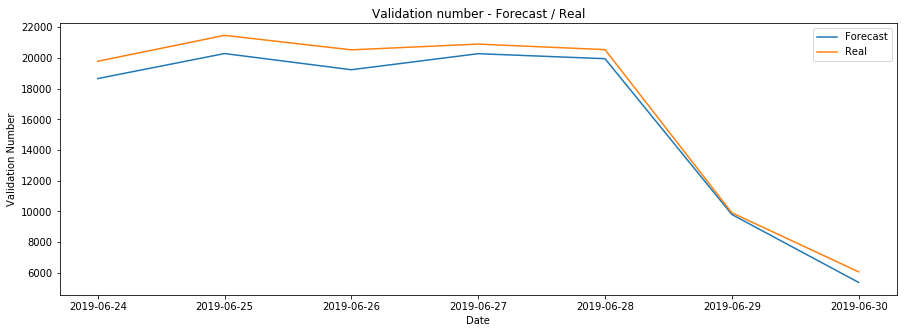

In [94]:
fig, ax = plt.subplots(1, 1,figsize=(15, 5), sharex=True)

ax.set_xticklabels(test_data.ds.dt.date)
sns.lineplot(x=test_data.ds.dt.date, y=sum_prev, ax=ax)
sns.lineplot(x=test_data.ds.dt.date, y=sum_real, ax=ax)
ax.legend(labels=["Forecast", "Real", "Forecast Interval"]);
ax.set_title("Validation number - Forecast / Real") 
ax.set_ylabel("%s" % "Validation Number")
ax.set_xlabel("Date")

In [95]:
print("R2-Score (Higher is better) : {0:.2f}%".format(r2_score(sum_real, sum_prev)))
print("MSLE (Lower is better) : {0:.2f}".format(mean_squared_log_error(sum_real, sum_prev)))
print("MAE (Lower is better) : {0:.2f}".format(mean_absolute_error(sum_real, sum_prev)))

R2-Score (Higher is better) : 0.98%
MSLE (Lower is better) : 0.00
MAE (Lower is better) : 803.40
